# Exploring the Dimension K of a Partial Order

This notebook illustrates:
1. **Definition** of partial‐order dimension and its relationship to $k$.
2. Why $dim(h)$ reflects complexity.
3. How changing $K$ above $dim(h)$ doesn't alter the partial order.
4. Basic functions for partial‐order manipulation and realizer construction.
5. Demonstration on the *crown poset* to show $dim(h) = n/2$

Refernce:
W. T. Trotter, Combinatorics and Partially Ordered Sets: Dimension Theory, (Johns Hopkins Univ. Press, 1992).
This monograph is a central text for the theory of dimension, realisers, and critical pairs.
It gives rigorous definitions of “critical pairs,” discusses minimal (critical) subposets that witness dimension, and includes proofs about how realisers must separate those pairs.

## 1. Definition of Dimension

We say a partial order $h = (X, \prec_h)$ has **dimension** $K$ if there exist $K$ total orders $\ell_1, \dots, \ell_K$ such that:

$x \prec_h y \quad \Longleftrightarrow \quad (x <_{\ell_k} y \text{ for each } k = 1, \dots, K)$.

If $\dim(h) = K$, then any $K+1$ columns (i.e., total orders) will still intersect to the same partial order as long as they don't introduce new forced edges. 

Essentially, **once the minimal $K$ is reached, adding more linear extensions won't change the partial order** as long as those additional extensions are "consistent."

Below, we'll show how this works in code by enumerating linear extensions and checking dimension on small examples.


In [2]:
import sys
# Add the path to the src directory to access utility modules and po_hm_mcmc.py
sys.path.append('../src')  # Adjust the path if your directory structure is different
 
sys.path.append('../src/utils')  # Ensure this path points to the directory containing your utility modules

# Import custom modules
from src.utils.basic_utils import BasicUtils
from src.utils.statistical_utils import StatisticalUtils
from src.utils.generation_utils import GenerationUtils
from src.visualization.po_plot import POPlot
from src.mcmc.likelihood_cache import LogLikelihoodCache
from src.mcmc.mcmc_simulation import mcmc_partial_order



# Adjust this path based on your directory structure
# Import necessary libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pygraphviz as pgv
from typing import List, Dict, Any
import seaborn as sns 
from scipy.stats import beta
import itertools
from math import inf
import numpy as np

import yaml
with open("/home/doli/Desktop/research/coding/BayesianPartialOrders/mcmc_config.yaml", "r") as f:
    config = yaml.safe_load(f)

ModuleNotFoundError: No module named 'src'

### Critical Pairs
A critical pair $(x,y)$ in a poset $P$ is an incomparable pair that, once forced into a certain order ($x \prec y$), induces further transitive orderings. Informally, each linear extension can only “resolve” some subset of these critical pairs, and one typically needs enough linear orders to cover such pairs.

In [9]:
# first to find the critical paris 
def find_critical_pairs(elements, adj):
    """
    Return all incomparable pairs (x,y), x<y lexicographically, 
    that are not in the transitive closure.
    """
    tc = BasicUtils.transitive_closure(adj)
    pairs = []
    n = len(elements)
    for i in range(n):
        for j in range(i+1, n):
            # If neither i -> j nor j -> i is in the closure, they are incomparable.
            if tc[i, j] == 0 and tc[j, i] == 0:
                pairs.append((elements[i], elements[j]))
    return pairs

## Realizer Definition
A realizer for a poset $h = (X, \prec)$ is a family of linear extensions $\{\ell_1, \dots, \ell_K\}$ such that:
$ h = \bigcap_{i=1}^K \ell_i.$

Equivalently, each pair $(x, y)$ that is not comparable in $h$ must be "flipped" in at least one extension, so that $y < x$ in that extension. Consequently, if $x$ and $y$ are incomparable, there must exist some $\ell_i$ where $y <_{\ell_i} x$.


In [ ]:
def realizer_to_partial_order_matrix(realizer, items=None):
    """
    Generate a partial order matrix from a collection of linear extensions.
    
    Parameters:
        realizer: A collection of linear extensions (each is a list/tuple of items).
        items: Optional list of items. If not provided, items are extracted from the realizer.
        
    Returns:
        A tuple (H, adj_dict) where:
          H: an n x n numpy array such that H[i,j] = 1 if every linear extension has items[i] before items[j].
          adj_dict: a dictionary with each key in items mapping to a set of items that follow it.
    """
    if items is None:
        items = sorted(set(item for ext in realizer for item in ext))
    item_index = {item: idx for idx, item in enumerate(items)}
    n = len(items)
    H = np.zeros((n, n), dtype=int)

    # For each pair (i,j) check if every extension orders items[i] before items[j].
    for i in range(n):
        for j in range(n):
            if i != j:
                H[i, j] = 1 if all(ext.index(items[i]) < ext.index(items[j]) for ext in realizer) else 0


    
    return H

def find_min_realizer_brute(h, items):
    """
This function is super expensive to run 
    """
    all_exts = BasicUtils.generate_all_linear_extensions(h, items)
    best_size = inf
    best_subset = None

    # For each combination of linear extensions (starting from size 1)
    for size in range(1, len(all_exts) + 1):
        for combo in itertools.combinations(all_exts, size):
            inter_matrix = realizer_to_partial_order_matrix(combo, items)
            # Convert inter_dict back to a matrix for comparison:
            if np.array_equal(BasicUtils.transitive_closure(inter_matrix),
                              BasicUtils.transitive_closure(h)):
                best_size = size
                best_subset = combo
                break
        if best_subset is not None:
            break

    return best_subset, best_size


## 2. Why $dim(h)$ reflects complexity.

- $\dim(h)$ measures complexity. If $\dim(h)$ is large (as in a crown poset), the partial order has many incomparable pairs that each need to be “flipped” at least once.
- In a Bayesian setting, letting $K$ vary means we perform *model selection* over partial-order complexity. For data that strongly suggests a simpler partial order, the posterior on $K$ might concentrate at smaller values, and so on.


Given the same node n, under different dim(h), we plot out differnt partial orders and understand the differences. Given the node n=8, we can take the K=2,3 and 4. The construcion of the partial orders are from the concept called realizers

Critical pairs (incomparable): 10
Critical pairs (incomparable): 18
Critical pairs (incomparable): 10


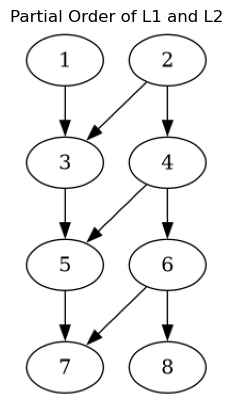

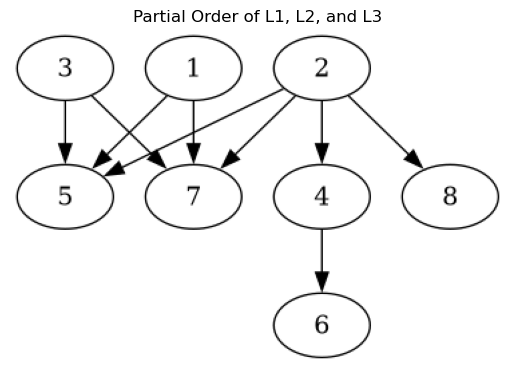

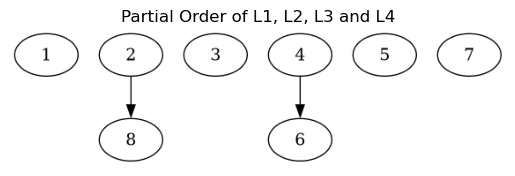

In [ ]:
items = [str(i) for i in range(1,9)]

L1 = ["1","2","3","4","5","6","7","8"]
L2 = ["2","4","6","8","1","3","5","7"]
L3 = ["3","1","2","7","5","8","4","6"]
L4 = ["4", "1", "2", "3", "8", "5", "6", "7"]  # this is by sovler from the crown graph

h2 = realizer_to_partial_order_matrix([L1, L2],items)
h3 = realizer_to_partial_order_matrix([L1, L2, L3],items)
h4 = realizer_to_partial_order_matrix([L1, L2, L3, L4],items)
cpairs2 = find_critical_pairs(items, h2)
cpairs3 = find_critical_pairs(items, h3)
cpairs4 = find_critical_pairs(items, h4)
print(f"Critical pairs (incomparable): {len(cpairs2)}")
print(f"Critical pairs (incomparable): {len(cpairs3)}")
print(f"Critical pairs (incomparable): {len(cpairs2)}")
PO_plot.visualize_partial_order(BasicUtils.transitive_reduction(h2), items, title="Partial Order of L1 and L2")
PO_plot.visualize_partial_order(BasicUtils.transitive_reduction(h3), items, title="Partial Order of L1, L2, and L3")
PO_plot.visualize_partial_order(BasicUtils.transitive_reduction(h4), items, title="Partial Order of L1, L2, L3 and L4")

subset2, size2 = find_min_realizer_brute(h2, items)
subset3, size3 = find_min_realizer_brute(h3, items)
subset4, size4 = find_min_realizer_brute(h4, items)

## 3. How changing $K$ above $dim(h)$ doesn't alter the partial order.

## 2. The Crown Poset

If $n = 2k$, we partition the set into two subsets:
$A = \{a_1, \dots, a_k\}$ and $B = \{b_1, \dots, b_k\}$.

We define the partial order such that $a_i \prec b_j$ if and only if $i \neq j$.

This poset is known as the **crown poset**, and it has dimension $k$. 

We'll verify this by enumerating all linear extensions and searching for the minimal subset whose intersection reproduces the crown.


In [ ]:
############################
# Section 2: Generating a Crown Poset
############################

def generate_crown_poset(k):
    """
    Return items, adj, and adj_matrix for a crown poset with n=2k elements.
    We'll label the elements as a1,...,aK, b1,...,bK with the rule: a_i -> b_j if i != j.
    
    Parameters:
        k: Number of a-items (and b-items), so total elements = 2k.
        
    Returns:
        items: List of items (strings) in the order [a1,...,aK, b1,...,bK].
        adj: A dictionary where each key is an item and the value is a set of items it points to.
        adj_matrix: A numpy array of shape (2k, 2k) representing the adjacency matrix.
                    For the ordering of items as above, adj_matrix[i, j] == 1 if there is an edge 
                    from items[i] to items[j], and 0 otherwise.
    """
    # Create items lists.
    A = [f"a{i}" for i in range(1, k+1)]
    B = [f"b{i}" for i in range(1, k+1)]
    items = A + B
    
    # Build adjacency dictionary.
    # Rule: For each a_i, add an edge to b_j if i != j.
    adj = {x: set() for x in items}
    for i, a_item in enumerate(A, start=1):
        for j, b_item in enumerate(B, start=1):
            if i != j:
                adj[a_item].add(b_item)
    
    # Build a mapping from item to its index.
    item_to_index = {item: idx for idx, item in enumerate(items)}
    
    # Create adjacency matrix.
    n = len(items)
    adj_matrix = np.zeros((n, n), dtype=int)
    for x, neighbors in adj.items():
        for y in neighbors:
            i = item_to_index[x]
            j = item_to_index[y]
            adj_matrix[i, j] = 1
            
    return items, adj, adj_matrix


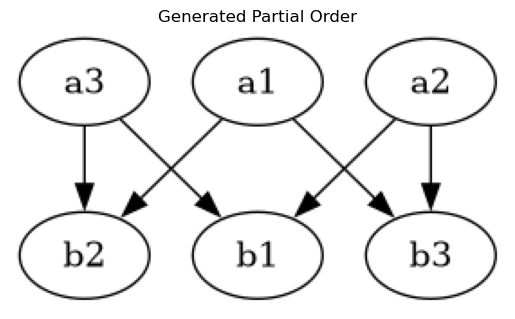

The targeted crown_po partial order h is : [[0 0 0 0 1 1]
 [0 0 0 1 0 1]
 [0 0 0 1 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]

--- Partial Order Description ---
Number of Nodes: 6
Number of Relationships: 6
Number of Alone Nodes: 0
Alone Nodes: []
Maximum In-Degree: 2
Maximum Out-Degree: 2
Maximum Relationships per Node: 2
Number of Linear Extensions: 48
Depth of Partial Order: 1
---------------------------------

Number of linear extensions found: 48.
[['a1', 'a2', 'a3', 'b1', 'b2', 'b3'], ['a1', 'a2', 'a3', 'b1', 'b3', 'b2'], ['a1', 'a2', 'a3', 'b2', 'b1', 'b3'], ['a1', 'a2', 'a3', 'b2', 'b3', 'b1'], ['a1', 'a2', 'a3', 'b3', 'b1', 'b2'], ['a1', 'a2', 'a3', 'b3', 'b2', 'b1'], ['a1', 'a2', 'b3', 'a3', 'b1', 'b2'], ['a1', 'a2', 'b3', 'a3', 'b2', 'b1'], ['a1', 'a3', 'a2', 'b1', 'b2', 'b3'], ['a1', 'a3', 'a2', 'b1', 'b3', 'b2'], ['a1', 'a3', 'a2', 'b2', 'b1', 'b3'], ['a1', 'a3', 'a2', 'b2', 'b3', 'b1'], ['a1', 'a3', 'a2', 'b3', 'b1', 'b2'], ['a1', 'a3', 'a2', 'b3', 'b2', 'b1'], ['

In [ ]:
############################
# Let's do a demonstration with k=3 => n=6
############################
k=4
items, adj, crown_po= generate_crown_poset(k)
PO_plot.visualize_partial_order(BasicUtils.transitive_reduction(crown_po), items,title='Generated Partial Order')
print(f"The targeted crown_po partial order h is : {crown_po}")

StatisticalUtils.description_partial_order(crown_po)

# Enumerate linear extensions
all_exts = BasicUtils.generate_all_linear_extensions(crown_po,items)
print(f"\nNumber of linear extensions found: {len(all_exts)}.")
print(all_exts)

## 3. Finding the Dimension
### 3.1 Find the critical pairs
We first need to find the critical pairs.

In [ ]:
critical_pairs = find_critical_pairs(items, crown_po)
print(f"\nCritical pairs: {critical_pairs}")
(f"The length of Critical pairs is: {len(critical_pairs)}")


Critical pairs: [('a1', 'a2'), ('a1', 'a3'), ('a1', 'b1'), ('a2', 'a3'), ('a2', 'b2'), ('a3', 'b3'), ('b1', 'b2'), ('b1', 'b3'), ('b2', 'b3')]


'The length of Critical pairs is: 9'


### 3.1 Brute Force Realizer Search

We try subsets of linear extensions, from smaller to larger, until we find the smallest set whose intersection matches the original poset $h$. 

That size is $\dim(h)$ by definition.




In [ ]:



realizer, size = find_min_realizer_brute(adj_matrix, items)
print(f"Brute force realizer size = {size}")
for s in realizer:
    print("  ", s)


Brute force realizer size = 3
   ['a1', 'a2', 'b3', 'a3', 'b1', 'b2']
   ['a1', 'a3', 'b2', 'a2', 'b1', 'b3']
   ['a2', 'a3', 'b1', 'a1', 'b2', 'b3']


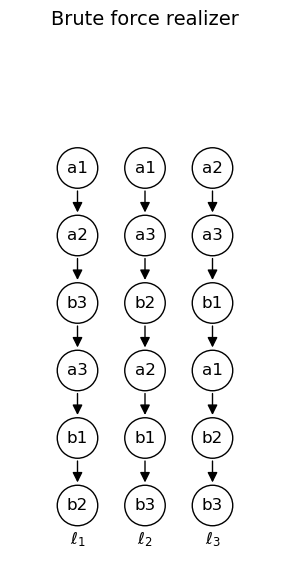

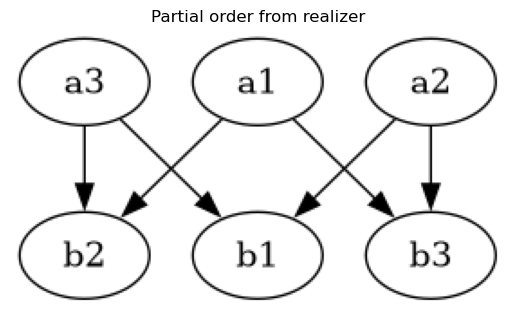

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyArrowPatch

def plot_linear_extensions_vertical(realizer):

    n_orders = len(realizer)
    n_items = len(realizer[0])
    
    # Define parameters for layout.
    gap = 1              # Horizontal gap between columns.
    node_radius = 0.3    # Radius for each circular node.
    top_y = n_items + 1  # Y-coordinate for the top (above the top node).
    
    # Create figure and axis.
    fig, ax = plt.subplots(figsize=(n_orders * gap, n_items + 2))
    
    for order_idx, order in enumerate(realizer):
        x = order_idx * gap  # x-coordinate for the column.
        # Draw each node from top to bottom.
        for pos, item in enumerate(order):
            # y-coordinate: top node at y = n_items, bottom node at y = 1.
            y = n_items - pos
            # Draw circle.
            circle = Circle((x, y), radius=node_radius, edgecolor='black',
                            facecolor='white', zorder=2)
            ax.add_patch(circle)
            # Annotate node with the item label.
            ax.text(x, y, str(item), fontsize=12, ha='center', va='center', zorder=3)
            
            # Draw arrow from current node to next, if not the last node.
            if pos < n_items - 1:
                start = (x, y - node_radius)
                end = (x, y - 1 + node_radius)
                arrow = FancyArrowPatch(start, end, arrowstyle='-|>', mutation_scale=15,
                                        color='black', linewidth=1, zorder=1)
                ax.add_patch(arrow)
        
        # Label the linear extension below the nodes.
        ax.text(x, 0.5, f"$\\ell_{{{order_idx + 1}}}$", fontsize=12, ha='center', va='center')
    
    # Set axis limits and remove axes.
    ax.set_xlim(-1, (n_orders - 1) * gap + 1)
    ax.set_ylim(0, n_items + 2)
    ax.set_aspect('equal')
    ax.axis('off')
    
    plt.title("Brute force realizer", fontsize=14)
    plt.tight_layout()
    plt.show()



plot_linear_extensions_vertical(realizer)

H = realizer_to_partial_order_matrix(realizer, items)
PO_plot.visualize_partial_order(H, items, title="Partial order from realizer")

### 3.2 Observing Dimension

We expect the crown poset with $k=3$ to have dimension $3$.
Hence, the minimal realizer found should have size 3.



In [ ]:
########################################
# 4. A simple "Critical Pair" approach
########################################


def realizer_via_critical_pairs(elements, adj):
    """
    Very naive approach: gather all incomparable pairs,
    iteratively pick a linear extension that flips many pairs,
    until all are covered. 
    """
    inc = set(critical_pairs(elements, adj))
    all_exts = enumerate_linear_extensions(elements, adj)
    
    coverage = []
    uncovered = set(inc)
    
    while uncovered:
        best_ext = None
        best_flips=0
        for ext in all_exts:
            pos = {xx:i for i,xx in enumerate(ext)}
            flip_count=0
            for (x,y) in uncovered:
                # flipping means y<x in ext
                if pos[y]<pos[x]:
                    flip_count+=1
            if flip_count>best_flips:
                best_flips=flip_count
                best_ext=ext
        
        coverage.append(best_ext)
        pos_map = {xx:i for i,xx in enumerate(best_ext)}
        new_uncov = set()
        for (x,y) in uncovered:
            if pos_map[y]<pos_map[x]:
                # covered
                pass
            else:
                new_uncov.add((x,y))
        uncovered=new_uncov
    
    return coverage

cover_set = realizer_via_critical_pairs(elements, adj)
print(f"Critical pair coverage yields realizer of size {len(cover_set)}")


NameError: name 'elements' is not defined